In [79]:
import os
train_path = "/local/crv/dataset/cloth3d/CLOTH3D/train/"
import glob
import numpy as np
import networkx as nx
import random
import math
import scipy.io
import k3d
import pickle as pkl
import matplotlib.pyplot as plt
import trimesh
import pandas as pd
import seaborn as sns

In [80]:

def readOBJ(file):
	V, Vt, F, Ft = [], [], [], []
	with open(file, 'r') as f:
		T = f.readlines()
	for t in T:
		# 3D vertex
		if t.startswith('v '):
			v = [float(n) for n in t.replace('v ','').split(' ')]
			V += [v]
		# UV vertex
		elif t.startswith('vt '):
			v = [float(n) for n in t.replace('vt ','').split(' ')]
			Vt += [v]
		# Face
		elif t.startswith('f '):
			idx = [n.split('/') for n in t.replace('f ','').split(' ')]
			f = [int(n[0]) - 1 for n in idx]
			F += [f]
			# UV face
			if '/' in t:
				f = [int(n[1]) - 1 for n in idx]
				Ft += [f]
	V = np.array(V, np.float32)
	Vt = np.array(Vt, np.float32)
	F = np.array(F)
	if Ft: assert len(F) == len(Ft), 'Inconsistent .obj file, mesh and UV map do not have the same number of faces' 
	else: Vt, Ft = None, None
	return V, F, Vt, Ft

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def rgb_to_hex(rgb):
    if rgb.dtype == np.uint8:
        pass
    elif rgb.dtype in (np.float16, np.float32, np.float64):
        # print('Assuming Value in [0.0, 1.0]')
        rgb = (rgb * 255).astype(np.uint8)
    assert(rgb.dtype == np.uint8)
    hex = np.sum(rgb.astype(np.uint32) * np.array([1, 256, 256 ** 2])[::-1], axis=-1)
    return hex

In [148]:
def main(threshold):
    plot = k3d.plot()
    train_path = "/local/crv/datasets/cloth3d/train/"
    os.chdir(train_path)
    dirs = os.listdir()
    random.shuffle(dirs)
    counter = 0
    stats = {
        'width':[],
        'height':[],
        'instance':[],
        'area':[],
    }
    for instance in dirs:
        dir_path = os.path.join(train_path, instance)
        os.chdir(dir_path)


        instance_name = glob.glob("*.obj")[0]
        if not("Tshirt" in instance_name):
            continue

        zrot = scipy.io.loadmat(glob.glob("*.mat")[0])["zrot"][0][0]

        full_path = os.path.join(dir_path, instance_name)

        V, F, Vt, Ft = readOBJ(full_path)

        # last_F = F.copy()[:,-1].reshape(-1, 1)
        # until_last_F = F.copy()[:, :-1]

        # G = nx.Graph()
        # nodes = np.arange(V.shape[0])
        # G.add_nodes_from(nodes)
        # edges = np.array([F, np.concatenate([last_F, until_last_F], 1)]).reshape(2, -1).transpose(1, 0)
        # G.add_edges_from(edges)

        # N = 0
        # for i in range(len(G.nodes)):
        #     n = len(list(nx.all_neighbors(G, i)))
        #     if n >= 4:
        #         G.remove_node(i)
        #         # if(n < 4):
        # connected_components = list(nx.connected_components(G))

        # component_lengths = []
        # for c in connected_components:
        #     component_lengths.append(len(c))
        # max_component_length = max(component_lengths)
        
        # if(max_component_length < threshold):
        #     print ("Tshirt")
        # else:
        #     print("Jacket")
        #     continue

        axis = [0, 0, 1]
        rot_matrix = rotation_matrix(axis, zrot)
        V = V @ rot_matrix

        max_height = np.max(V[:, 2])
        min_height = np.min(V[:, 2])
        height = max_height - min_height

        max_width = np.max(V[:, 0])
        min_width = np.min(V[:, 0])
        width = max_width - min_width

        # print("Height", height, "Width", width, "Depth", V[:, 1])
        max_diffs = np.max(V, axis=0) - np.min(V, axis=0)
        width = max_diffs[0]
        height = max_diffs[2]
        area = height * width
        print(np.max(V, axis=0) - np.min(V, axis=0))
        w2h = max_diffs[0]/max_diffs[2]
        print("width to height", w2h)

        if w2h < 1.4 or w2h > 2.4 or area < 0.55:
            continue 


        stats['height'].append(height)
        stats['width'].append(width)
        stats['instance'].append(instance)
        stats['area'].append(area)


       

        # print(Vt.shape, rot_matrix.shape)
        # print(Vt)

        # Vt = Vt @ rot_matrix
        
        diffs = []
        mins = []
        for i in range(3):
            dim_max = np.max(V[:, i])
            dim_min = np.min(V[:, i])
            mins.append(dim_min)
            diffs.append(dim_max - dim_min)

        diffs = np.array(diffs)
        mins = np.array(mins)

        NOCS = (V.copy() - mins)/diffs

        # G = nx.Graph()
        # nodes = np.arange(V.shape[0])
        # G.add_nodes_from(nodes)
        # last_F = F.copy()[:,-1].reshape(-1, 1)
        # until_last_F = F.copy()[:, :-1]
        # edges = np.array([F, np.concatenate([last_F, until_last_F], 1)]).reshape(2, -1).transpose(1, 0)
        # print(edges.shape)
        # G.add_edges_from(edges)

        # print("Connected components", len(list(nx.connected_components(G))))
        # print(F.shape)
        # tri_faces=trimesh.Trimesh(V, F, Vt, Ft).faces.astype(np.uint32)

        # plot.colorbar_object_id = -1
        # mesh = k3d.mesh(V, F, attribute=rgb_to_hex(NOCS), height=1)
        # plot += mesh
        # plot.display()
        # mesh.colors = rgb_to_hex(NOCS)
        # break

        
        data = {
            'verts':V, 
            'nocs':NOCS,
            'faces':F
        }
        
        # save_path = os.path.join('/local/crv/acanberk/folding-unfolding/src/cloth_data/pickle_export/Shirt', instance + "_Shirt.pkl")
        # print(save_path)
        # with open(save_path, 'wb') as handle:
        #     pkl.dump(data, handle)
        # counter += 1


    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    df = pd.DataFrame.from_dict(stats)
    sns.histplot(data=df, x="height", ax=axs[0])
    sns.histplot(data=df, x="width", ax=axs[1])
    sns.histplot(data=df, x="area", ax=axs[2])
    # plt.close()
    # sns.histplot(data=df['width'],x="width")
    # plt.close()
    # sns.histplot(data=(df['height'] * df['width']), x="area")
    # plt.close()
    
    print(counter, " shirts")
        


[1.35590246 0.28207817 0.63310813]
width to height 2.141660153226428
/local/crv/acanberk/folding-unfolding/src/cloth_data/pickle_export/Shirt/05270_Shirt.pkl
[0.43004335 0.24688912 0.3544677 ]
width to height 1.213208824889018
[0.82864259 0.38857285 0.46068193]
width to height 1.7987303873280436
[1.0101105  0.28359245 0.66321998]
width to height 1.523039916243561
/local/crv/acanberk/folding-unfolding/src/cloth_data/pickle_export/Shirt/00187_Shirt.pkl
[0.99144879 0.2550477  0.5480171 ]
width to height 1.8091566538042532
[1.12835072 0.23980305 0.38031642]
width to height 2.9668735132910777
[1.30471336 0.36483626 0.62939104]
width to height 2.0729773298078893
/local/crv/acanberk/folding-unfolding/src/cloth_data/pickle_export/Shirt/03791_Shirt.pkl
[0.76733114 0.33774495 0.3637028 ]
width to height 2.1097751541898546
[1.2259398  0.34121968 0.63645641]
width to height 1.9261960271694663
/local/crv/acanberk/folding-unfolding/src/cloth_data/pickle_export/Shirt/01742_Shirt.pkl
[1.15253606 0.258

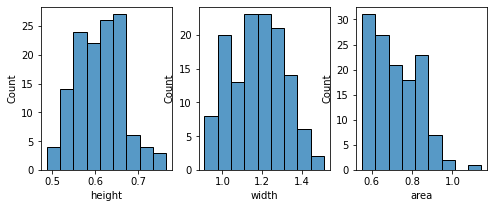

In [149]:
main(180)